### 天梯duration处理方法的尝试

In [2]:
from impala.dbapi import connect
import pandas as pd
from collections import defaultdict
import trueskill as ts
import multiprocessing as mps
import numpy as np

### 连接HUE数据库

In [3]:
conn = connect(host='10.8.8.21', port=10015, auth_mechanism='PLAIN', database='tmp', user='shenfei',password='123456')
cursor = conn.cursor()

### 从数据库中取出数据，并同时按照day和提交时间两个字段对所有数据排序

In [4]:
cursor.execute('''
SELECT t1.*, t2.goal_id
FROM
(
    SELECT id, u_user, problem_id,duration, day, correct, u_school, from_unixtime(event_time/1000) AS time
    FROM events.frontend_event_orc
    WHERE day BETWEEN 20181001 AND 20181031
      AND event_key = 'clickLTTPSumbit'
      AND u_user != ''
      AND u_user IS NOT NULL
      AND u_school IS NOT NULL
      AND u_school IN ('新民中学', '莒南七中', '临沂十一中', '南宁二中', '广东实验中学', '双语学校', '武陵中学', '吴有训实验学校', '武侯实验中学', '城关中学')
)t1
INNER JOIN
(
    SELECT id, goal_id
    FROM course.problem
)t2 ON t1.problem_id = t2.id
ORDER BY t1.day,t1.time ASC
''')

data = cursor.fetchall()
data = pd.DataFrame(data)
data.columns = ['id', 'uid', 'pid', 'dur', 'day', 'corr', 'sch_name', 'time', 'gid']
data['ts_pts'] = 0 

### 看看数据——

In [5]:
data.tail(5)

,id,uid,pid,dur,day,corr,sch_name,time,gid,ts_pts
269899,5bd9cf044e4fa563c93e52e7,5bd9b32b37a1c6078d7ba59f,18db632a-75ca-11e7-b80b-e7218667489c,34909,20181031,1,新民中学,2018-10-31 23:49:13,9690ebf2-53f4-11e7-8610-ffb838397af0,0
269900,5bd9cf254e4fa563c93e8d63,5bd9b32b37a1c6078d7ba59f,6069ab72-75c3-11e7-b414-efbc79ae5142,20057,20181031,1,新民中学,2018-10-31 23:49:36,9690ebf2-53f4-11e7-8610-ffb838397af0,0
269901,5bd9cf494e4fa563c93ed0c9,5bd9b16971de5007ba60ace7,b9a921de-57e8-11e7-b9af-6ba7df29752e,16501,20181031,1,新民中学,2018-10-31 23:50:26,973a0106-53f4-11e7-8654-0718617ce756,0
269902,5bd9cf6d4e4fa563c93f1439,5bd9b16971de5007ba60ace7,5cd36af8-7b3a-11e7-aa1c-8705033a2960,36023,20181031,1,新民中学,2018-10-31 23:51:03,973a0106-53f4-11e7-8654-0718617ce756,0
269903,5bd9d0454e4fa563c9406c7d,5bd9b16971de5007ba60ace7,4427c682-7b46-11e7-8132-3fb936db8a73,212988,20181031,1,新民中学,2018-10-31 23:54:37,974564ce-53f4-11e7-8657-27a134c53335,0


$$compensate = \left (\frac{\mu_{g}}{\mu_{u}} - 1  \right ) \cdot b$$  
在此十所学校数据集中，$$(b\approx 0.043)$$
$$\Delta = \frac{\mu_g}{\mu_u} \cdot norm\_d(duration) + compensate,$$
where
<img src="https://images-cdn.shimo.im/zkpSlHD52FE0vDaz/%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7_2018_06_11_%E4%B8%8B%E5%8D%882.45.06.png!thumbnail" style="width:500px"/>
(when 'corr' == 1)

### 观察duration数据：
- 先按照一样多的user的做题记录来划分区间，不同的goal分开绘图

In [6]:
pick_dur = data[['gid','dur','corr']]
# pick_dur.groupby('gid').apply(lambda x:x.sort_values(by='dur'))    # 每个goal都按照dur排序，看看corr如何

# 按goal被user做的数量排序，我们先选取被做最多的10个goal进行绘图
goal_sort = pick_dur.groupby('gid').apply(lambda x:len(x)).sort_values(ascending=False)   
goal_sort

gid
9690ebf2-53f4-11e7-8610-ffb838397af0    5783
5923151c-72ba-11e7-abef-2f750a230c53    5136
96a01c62-53f4-11e7-8615-c7a25e0cd590    4316
967146a8-53f4-11e7-8607-cb93d0916896    3713
969730b6-53f4-11e7-8612-7b98a235568d    3422
9635512a-53f4-11e7-85f7-f3cd0a13a1b3    3230
96aa4db8-53f4-11e7-8618-b396d2878048    2924
9694aff8-53f4-11e7-8611-47dabd54b1c2    2671
97e09db8-53f4-11e7-8683-2b3d73ecba1d    2591
9c6b5346-53f4-11e7-87f4-7f0989ac4283    2456
965a2e46-53f4-11e7-8601-a7cc3089867f    2380
968e5bbc-53f4-11e7-860f-abb24d6e901f    2291
9d431ce0-53f4-11e7-884a-ab8aca084662    2191
9645f6c4-53f4-11e7-85fc-7b1f9c0df003    2044
96499a68-53f4-11e7-85fd-2b8a485ce5da    2020
98bdd124-53f4-11e7-86c7-1fecc8bde650    1897
6c815726-7356-11e7-a83b-ebcd0a538b70    1864
9dcdc76e-53f4-11e7-8876-df810d037a49    1845
968bd3a6-53f4-11e7-860e-9f154aae5872    1741
9c8ab9c0-53f4-11e7-87fd-63873e9ac20a    1735
973a0106-53f4-11e7-8654-0718617ce756    1711
96a3f21a-53f4-11e7-8616-5bf7296ab17e    1698
965173

### 等用户数分组，防止出现区间人数太少所导致的异常值：

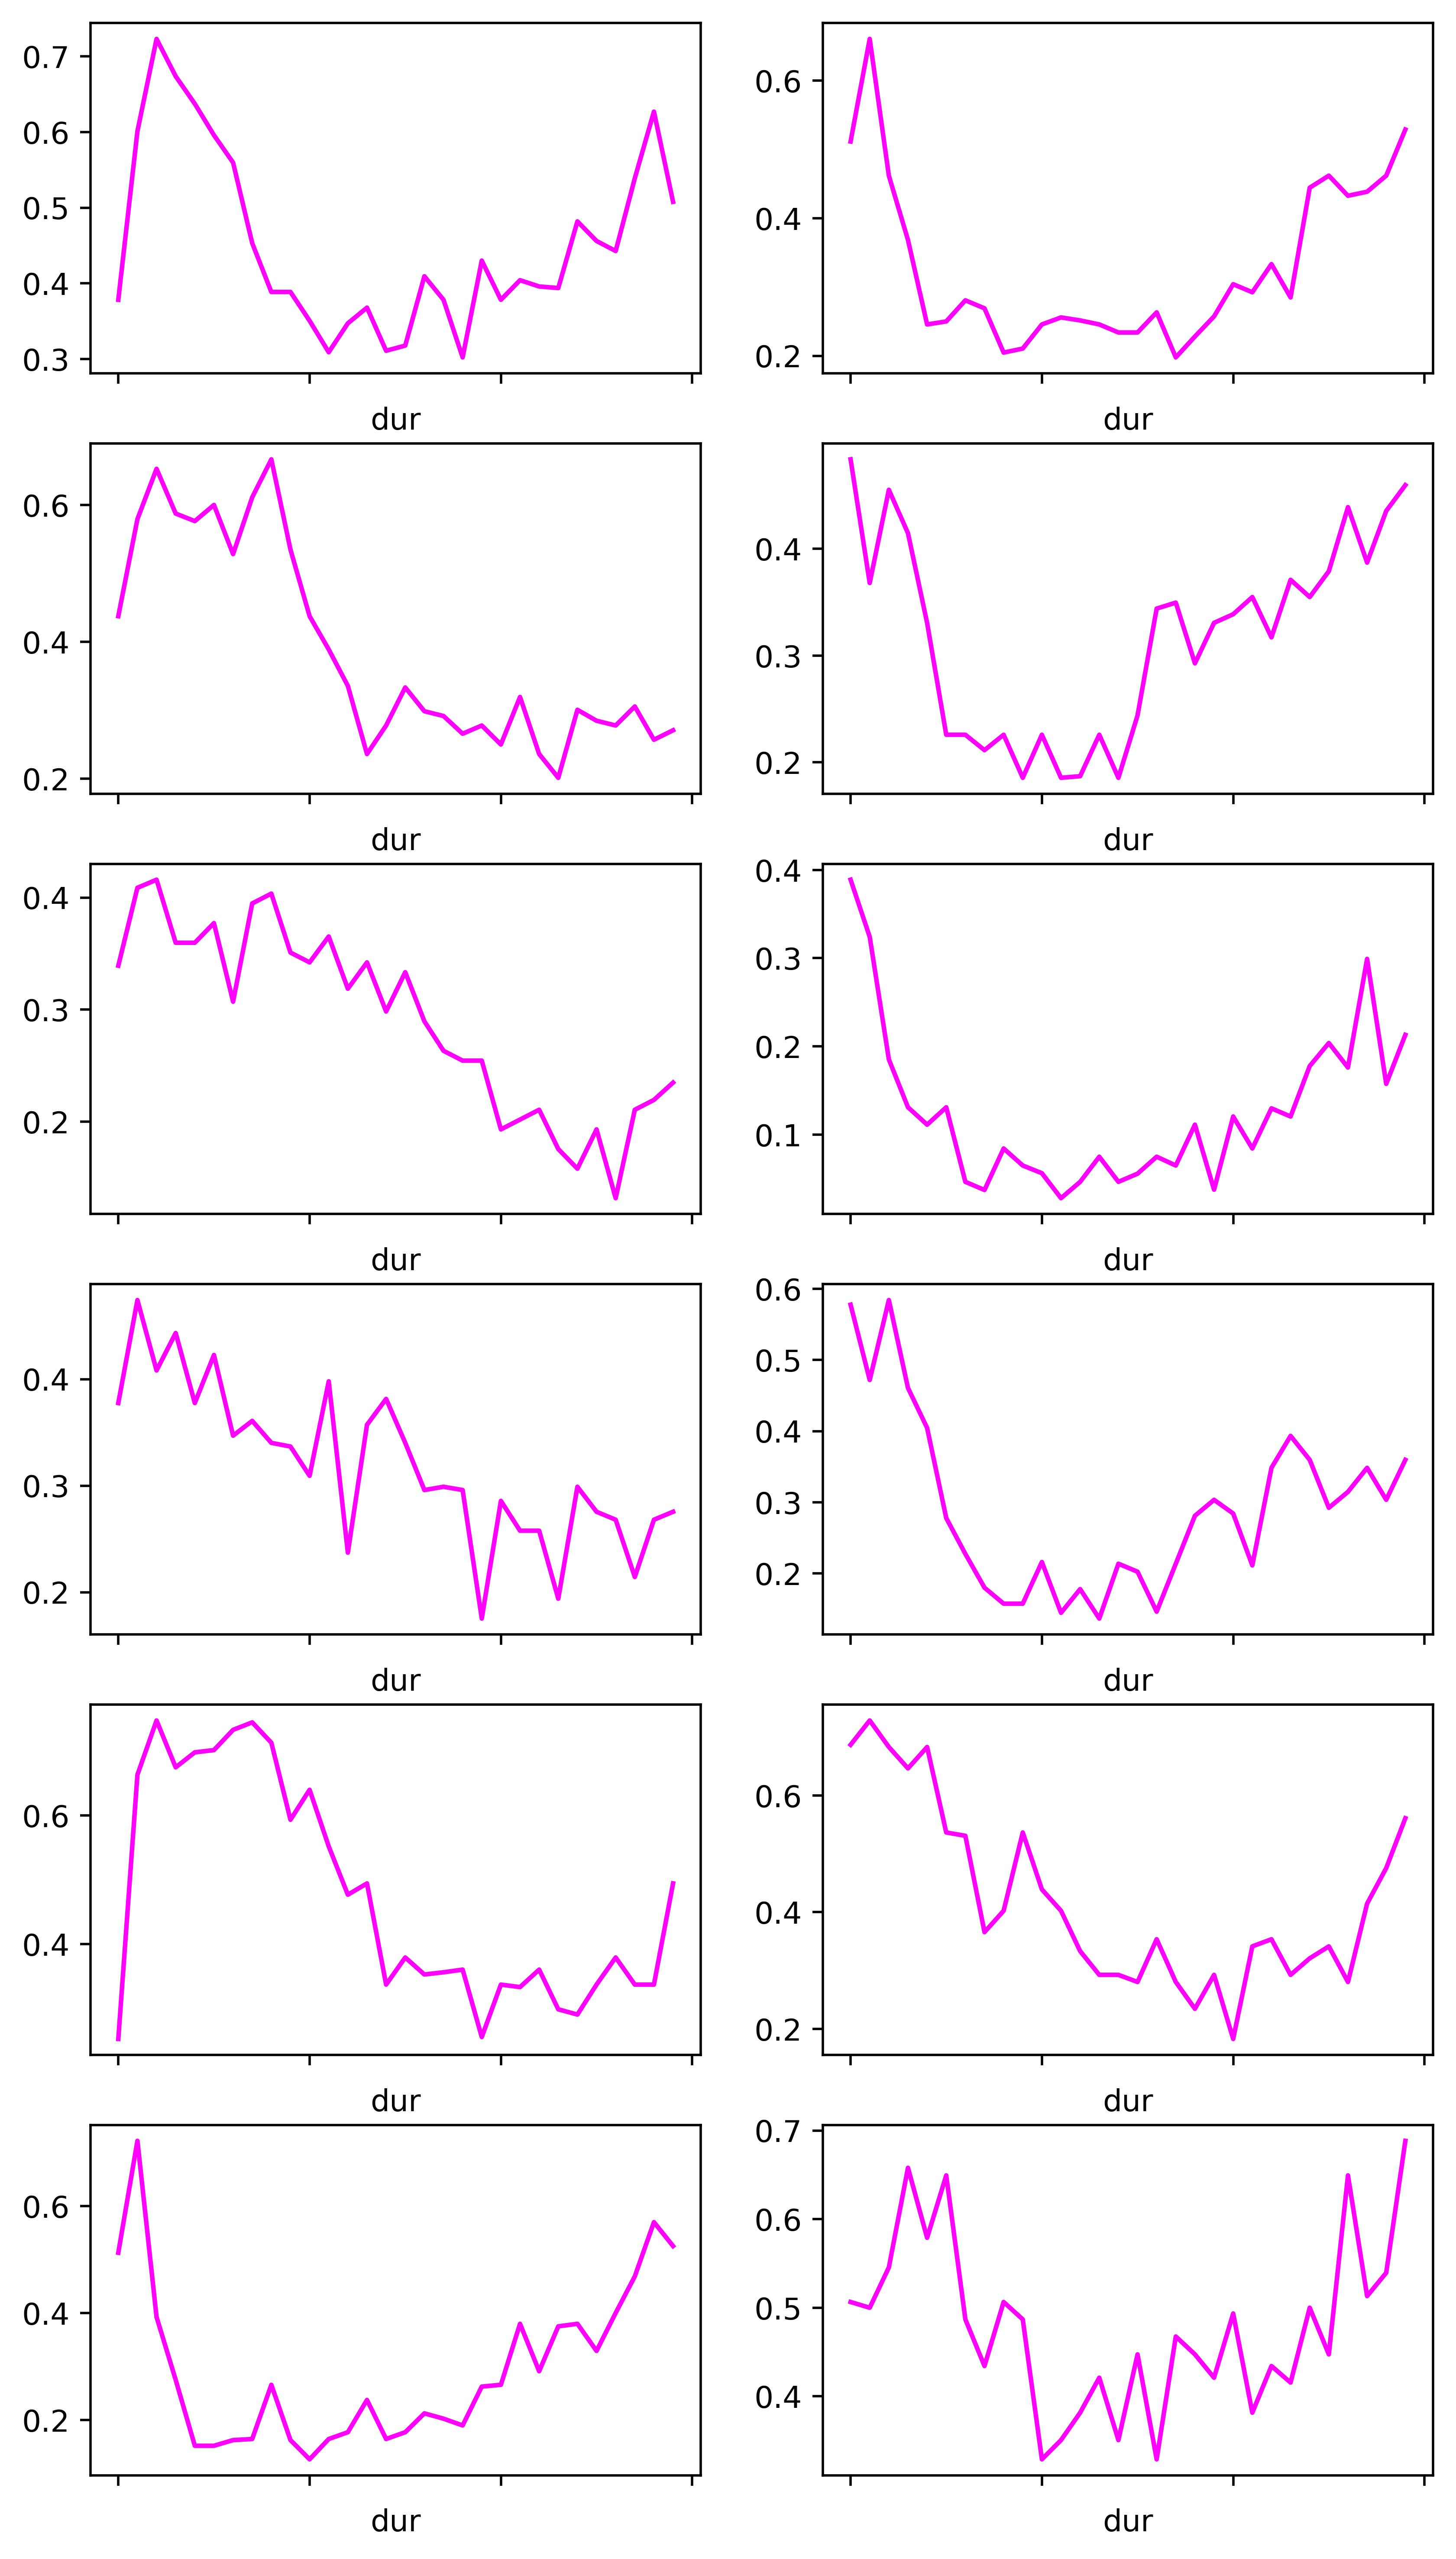

In [8]:
# 对分好组的数据，展示前十个gid对应的做题记录下，dur时长和corr错误率之间的关系。
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(8,15),dpi=500)
size = 12
res = []
ax = list(range(size))
for i in range(size):
    ax[i] = fig1.add_subplot(size/2,2,i+1)
    
    # 根据qcut进行数据分箱，按照分箱结果进行groupby分组，并对每组的数据的corr进行加和，计算错误率
    # 1,先取出对应轮次的goal的所有记录（第一轮就是goal1）：
    record = pick_dur[pick_dur.gid == goal_sort.index[i]]
    # 2,对取到的数据进行分箱，按照分箱结果groupby分组，组内计算正确率,然后直接画出来：
    data_draw = record.groupby(pd.qcut(record['dur'],q=30)).apply(lambda x:sum(x['corr'] == 0)/len(x))
#     diff = record.groupby(pd.qcut(record['dur'],q=30)).apply(lambda x:x['dur'].max() - x['dur'].min())  # 看看各区间长度
    res.append((i+1,(sum(record['corr'])/len(record['corr']))))
    data_draw.plot(kind='line',colormap='spring')

In [9]:
res

[(1, 0.5483313159259899),
 (2, 0.6713395638629284),
 (3, 0.6126042632066728),
 (4, 0.6821976838136278),
 (5, 0.7098188194038574),
 (6, 0.8739938080495356),
 (7, 0.6809165526675787),
 (8, 0.7083489329839011),
 (9, 0.5256657661134697),
 (10, 0.5810260586319218),
 (11, 0.7046218487394958),
 (12, 0.5211697948494107)]

### 对全部题目进行绘图，不区分二级目标goal。由于题目更多，区间更加细分

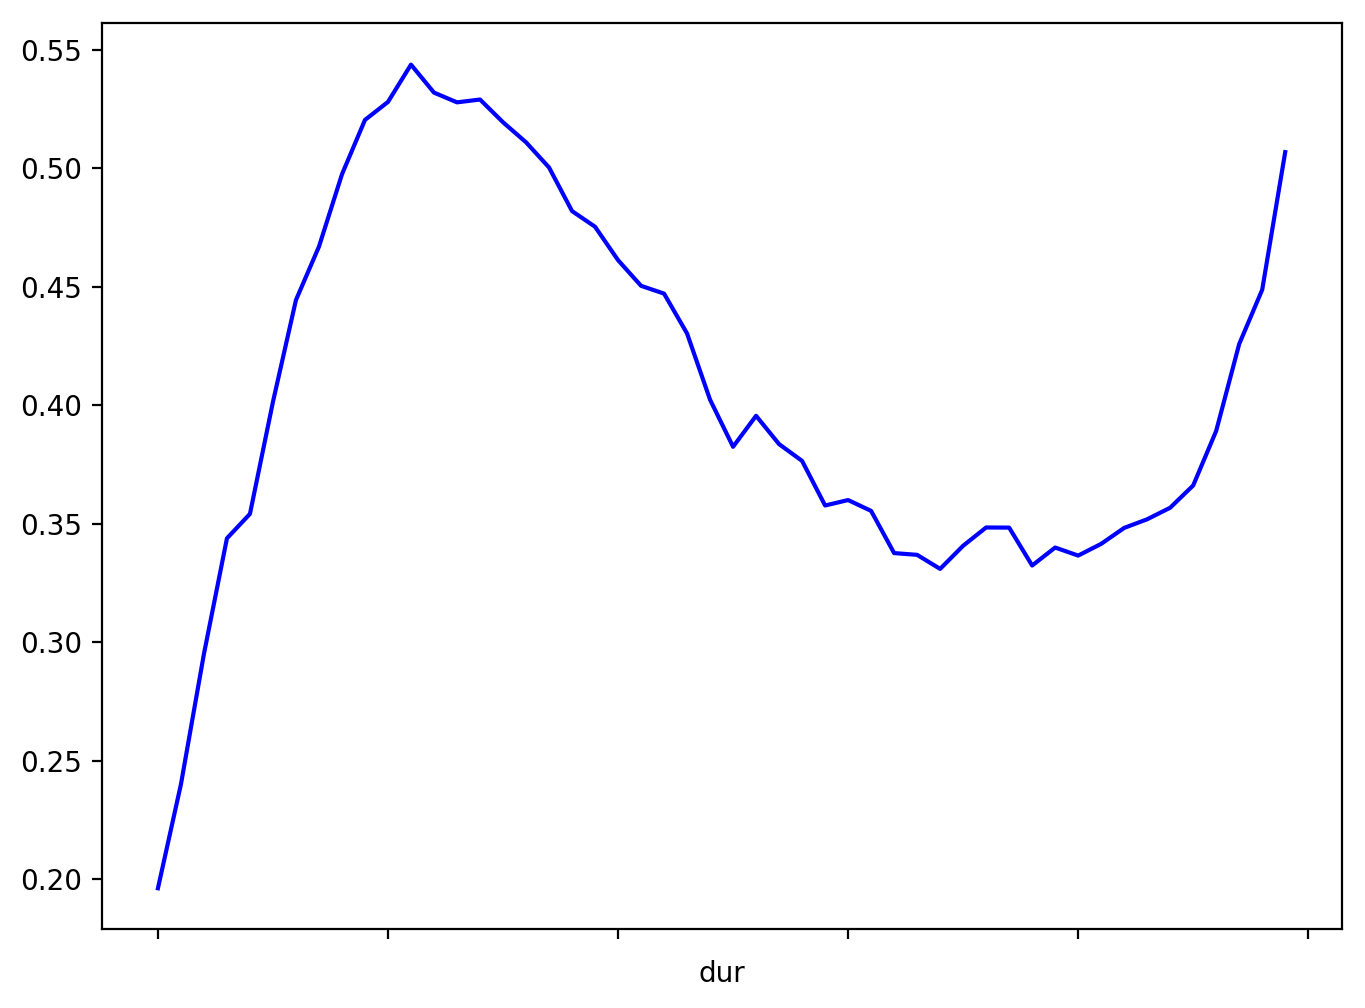

In [10]:
draw_qcut = pick_dur.groupby(pd.qcut(pick_dur.dur,q=50)).apply(lambda x:sum(x['corr']==0)/len(x))
fig3 = plt.figure(figsize=(8,6),dpi=200)
ax3 = fig3.add_subplot(111)
draw_qcut.plot(kind='line',colormap='winter')

### 等区间长度分组——防止上一中分割方式中某一时间段的duration人太少导致的区间“篡位”的问题，但相应的也可能会有异常，即这一区间内记录数为0：

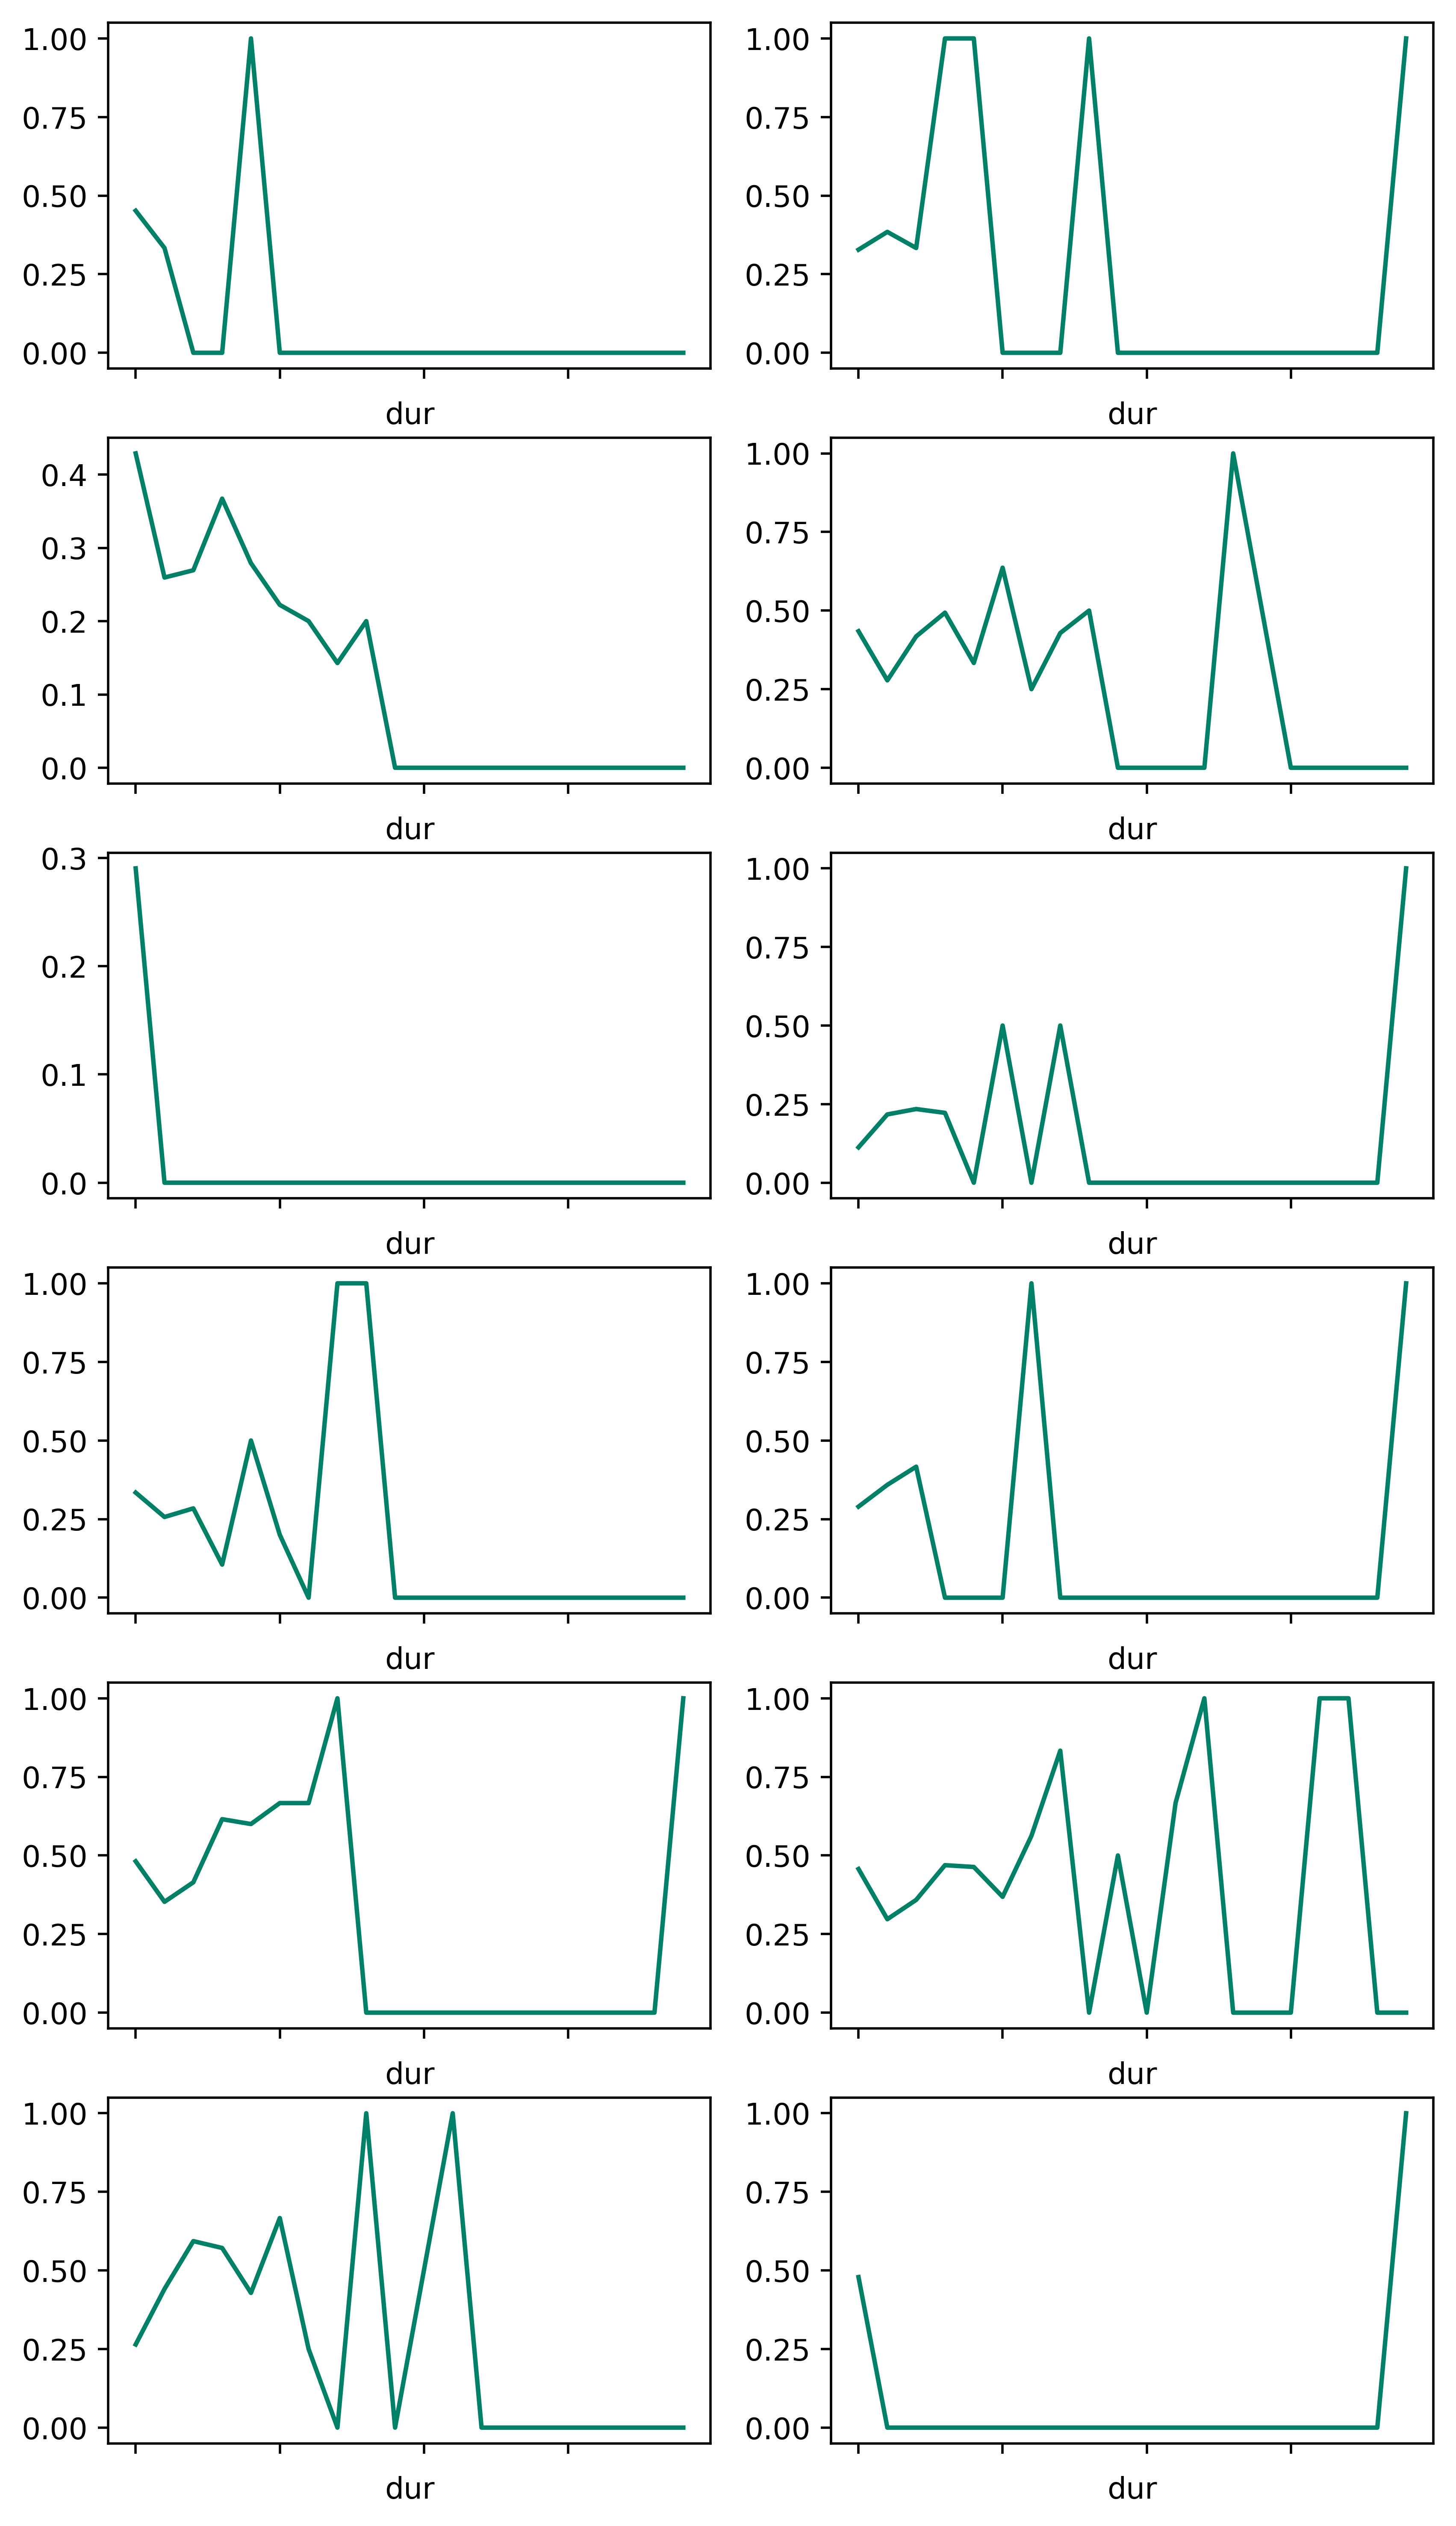

In [11]:
fig2 = plt.figure(figsize=(8,15),dpi=500)

for i in range(size):
    ax[i] = fig2.add_subplot(size/2,2,i+1)
    
    record2 = pick_dur[pick_dur.gid == goal_sort.index[i]]
    draw = record2.groupby(pd.cut(record2['dur'],bins=20)).apply(lambda x:sum(x['corr']==0)/len(x) if len(x)!=0 else 0)
    draw.plot(kind='line',colormap='summer')

1. 等长区间分组不太靠谱
2. 等记录数分组有一个基本的趋势，即在很短的时间内达到错误率巅峰，然后逐渐下降达到错误率最低，最后随着duration的加长，再次上升。但并非所有题目都有很明显的这样的趋势。
3. 我们的目标，是通过对duration的合理处理，从而将瞎蒙的user的做题记录的影响减少到最小、让他们的真是实力得以反馈。从这样的角度出发，我觉得我之前做的处理方式似乎就可以达到目标——当duration越短，其正误就越不可信（瞎蒙的概率越大），而当duration短而且还错的情况下，我们乘以最小的权重~0.18，意味着我们尽可能的最小化这个我们判断可能是瞎蒙值的影响。——相反，问题可能出在正确的题目上——duration越短，当做对的情况下，我们是乘以最大的权重1，这样可能褒奖了那些快速蒙对的用户了。
4. 姬老板的意思——当做错时，我们不应该用线性的方法去对duration进行处理，像做对时那样。原因是，错题数-duration的曲线图并非线性，其似乎是由两个正态分布组合而成。但问题是，正确数-duration曲线肯定也不是线性的呀，我们略显僵化的评分标准，不是为了拟合自然的做题状态，而是通过平分的一种促进方式——促进user做的又对又快，而这真的是我们的目标——与此同时，也要警惕那些通过瞎蒙想达到又对又快的人，最好是滤掉这样的情况。
5. 所以我觉得线性处理反而挺有道理的——
    - 最小化瞎蒙且蒙错了的情况，防止有人恶意刷错题给这个学校抹黑；
    - duration又长又错的，理应扣除最多的分数，到这个阶段，几乎都是认真做了但仍旧错了的，因而可以反映出这个user的真实实力（是真菜），所以乘以较大的权重的确应该如此；
    - 我们为什么要在评分的时候考虑做题正确率这种自然的规律？这种规律客观存在，但一直以来近线性评分的目的在于，鼓励大家高效地做对。我们做这个评分方式，一方面是为了去最好的反映出user们的实力，另一方面是鼓励高效做对，而且二者不矛盾——最快做对的永远是最厉害的user，相对的即便做对但耗时很长就显然不如前者，而如果你还错了，那么我们就更有把握认为你水平较差。
    - 正确率曲线，所反映出的规律ß，只是大部分人的水平。

总结：
- 从哪个角度出发去分析？从目标入手——我们是为了最好的反应答题者实力；同时促进user做的又对又快。
    - 反应实力而言，我们要减小duration很短但做错的记录的影响，因为这些很可能是user瞎蒙的记录（这一点已经办到）；此外，我们认为，在保证正确的前提下，做的越快说明你实力越强。因而duration越长权重越大，的确可以反映出你的实力（至少我们认为如此）（这一点也已经办到）
- 辨析：错误率的曲线反映的是客观规律。而我们处理duration的目的是从时间的角度去最大程度地反应一个人的实力。
    - 在duration中间部位，错误率最低，不意味着在这段duration内提交的人的实力最强（也就是说这里不值得去乘以100%的权值去褒奖他们的实力），而是说明实力使然的，使大部分人提交都在这个duration时间段内的人，是最多的，这里是正态分布的轴所在位置。